In [8]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as const
from scipy import interpolate
from classy import Class
import scipy.special
plt.style.use('seaborn')
%matplotlib notebook

# RK4 and growth equation

$$\ddot{\delta} + 2H\dot{\delta}-(3/2) H^2 \Omega_m \delta =0$$

$$\rightarrow \dot{\delta} = u$$

$$\rightarrow \dot{u} = (3/2) H^2 \Omega_m \delta - 2Hu$$

In [160]:
omega0R = 8.4e-5
omega0M = 0.3
omega0L = 1. - omega0R - omega0M
H0 = 70 * (1*u.km /(1*u.Mpc)).to('').value * (1/u.s).to('1/Gyr').value

def dadt(t, p):
    return np.sqrt(omega0R * np.power(p[2],-2) + omega0M * np.power(p[2],-1) + omega0L * np.power(p[2],2)) * H0

def dddt(t, p):
    return p[1]

def dudt(t, p):
    H = dadt(t,p)/p[2]
    return 3/2 * H0**2 * omega0M/p[2]**3 * p[0] - 2*H*p[1]

In [161]:
def RK4(dydts,tstart,tstop,nt,p0,tspace='log',stopcond=None):
    """
    Function for solving set of diff. eqs of the form dy/dt  = f(t, y) with the Runge Kutta 4 algorithm.
    Non-adaptive stepsize!
    """
    nsystems = len(dydts) #Number of dydts aka size of equation system
    stopcondIndex = np.where(stopcond != None)[0][0] #Index of stopcond where condition is set
    
    # --- Raise error if more than one stop-condition ---
    if len(np.where(stopcond != None)[0]) > 1:
        raise Exception("Only one stop condition at a time")

    # --- Setup arrays ---
    if tspace == 'log':
        ts = np.logspace(np.log10(tstart),np.log10(tstop),nt)
    elif tspace == 'lin':
        ts = np.linspace(tstart,tstop,nt)
        
    # --- Construct dts---
    dts   = np.diff(ts)

    # --- Unify diff. eqs to one ---
    def dydt(t,p):
        return np.array([_dydt(t,p) for _dydt in dydts])
    
    # --- Integrate ---
    yvals = np.array([p0])
    tvals = np.array([tstart])
    for (i,dt) in enumerate(dts):
        k1 = dt * dydt(ts[i],yvals[i])
        k2 = dt * dydt(ts[i] + dt/2, yvals[i] + k1/2)
        k3 = dt * dydt(ts[i] + dt/2, yvals[i] + k2/2)
        k4 = dt * dydt(ts[i] + dt, yvals[i] + k3)
        yvals = np.vstack([yvals,yvals[i] + k1/6 + k2/3 + k3/3 + k4/6])
        tvals = np.vstack([tvals,tvals[i] + dt])

        # --- Checks if the step taken has overshot a stop condition --
        if not (i == 0 or i == len(ts)) and np.any(stopcond != None):
            hasSteppedTooFar = np.any(((yvals[i+1][stopcondIndex] > stopcond[stopcondIndex]) and (yvals[i][stopcondIndex] < stopcond[stopcondIndex])) or ((yvals[i+1][stopcondIndex] < stopcond[stopcondIndex]) and (yvals[i][stopcond != None] > stopcond[stopcondIndex])))
            if hasSteppedTooFar:
                # Build interpolation functions to get (t,yvals) at exact stop condition
                interpfunc = interpolate.interp1d(yvals[:,stopcondIndex], yvals, axis=0)
                interptsfunc = interpolate.interp1d(yvals[:,stopcondIndex], tvals, axis=0)

                #Evaluate and set tvals,yvals
                valsAtStopCond = interpfunc(stopcond[stopcondIndex])
                yvals[i+1] = valsAtStopCond
                tAtStopCond = interptsfunc(stopcond[stopcondIndex])
                tvals[i+1] = tAtStopCond
                return tvals,yvals
    return tvals, yvals

# Evaluer

In [162]:
astart    = 1e-7
tstart    = 1/(np.sqrt(omega0R) * H0) * 1/2 * astart**2
tstop     = 14 #* 1e9 * 365 * 24 * 60 * 60
dstart    = 0.01
ddotstart = 0

ts, vals = RK4([dddt,dudt,dadt],tstart=tstart,tstop=tstop,nt=10000,p0=[dstart,ddotstart,astart],stopcond=np.array([None,None,1]))
Hs = np.array([dadt(t,val)/val[2] for t,val in zip(ts,vals)])
#f = 1/H * 1/delta * ddelta/dt
fs = 1/Hs * 1/vals[:,0] * vals[:,1]

In [163]:
# --- Generate values for comparison ---
analyticalAs = (np.sinh(H0*3*ts/2 * np.sqrt(omega0L))**2 * omega0M/omega0L)**(1/3)
paperxs = omega0L/omega0M * vals[:,2]**3
analyticalDs = vals[:,2] * scipy.special.hyp2f1(1/3,1,11/6,-paperxs)

# --- Class results for comparison ---
cosmo = Class()
Omega_b = 0.05
cosmo.set({'Omega_b':Omega_b, 'Omega_cdm':omega0M - Omega_b, 'H0':70})
cosmo.compute()
bg = cosmo.get_background()
d = bg['gr.fac. D']
f = bg['gr.fac. f']

<IPython.core.display.Javascript object>


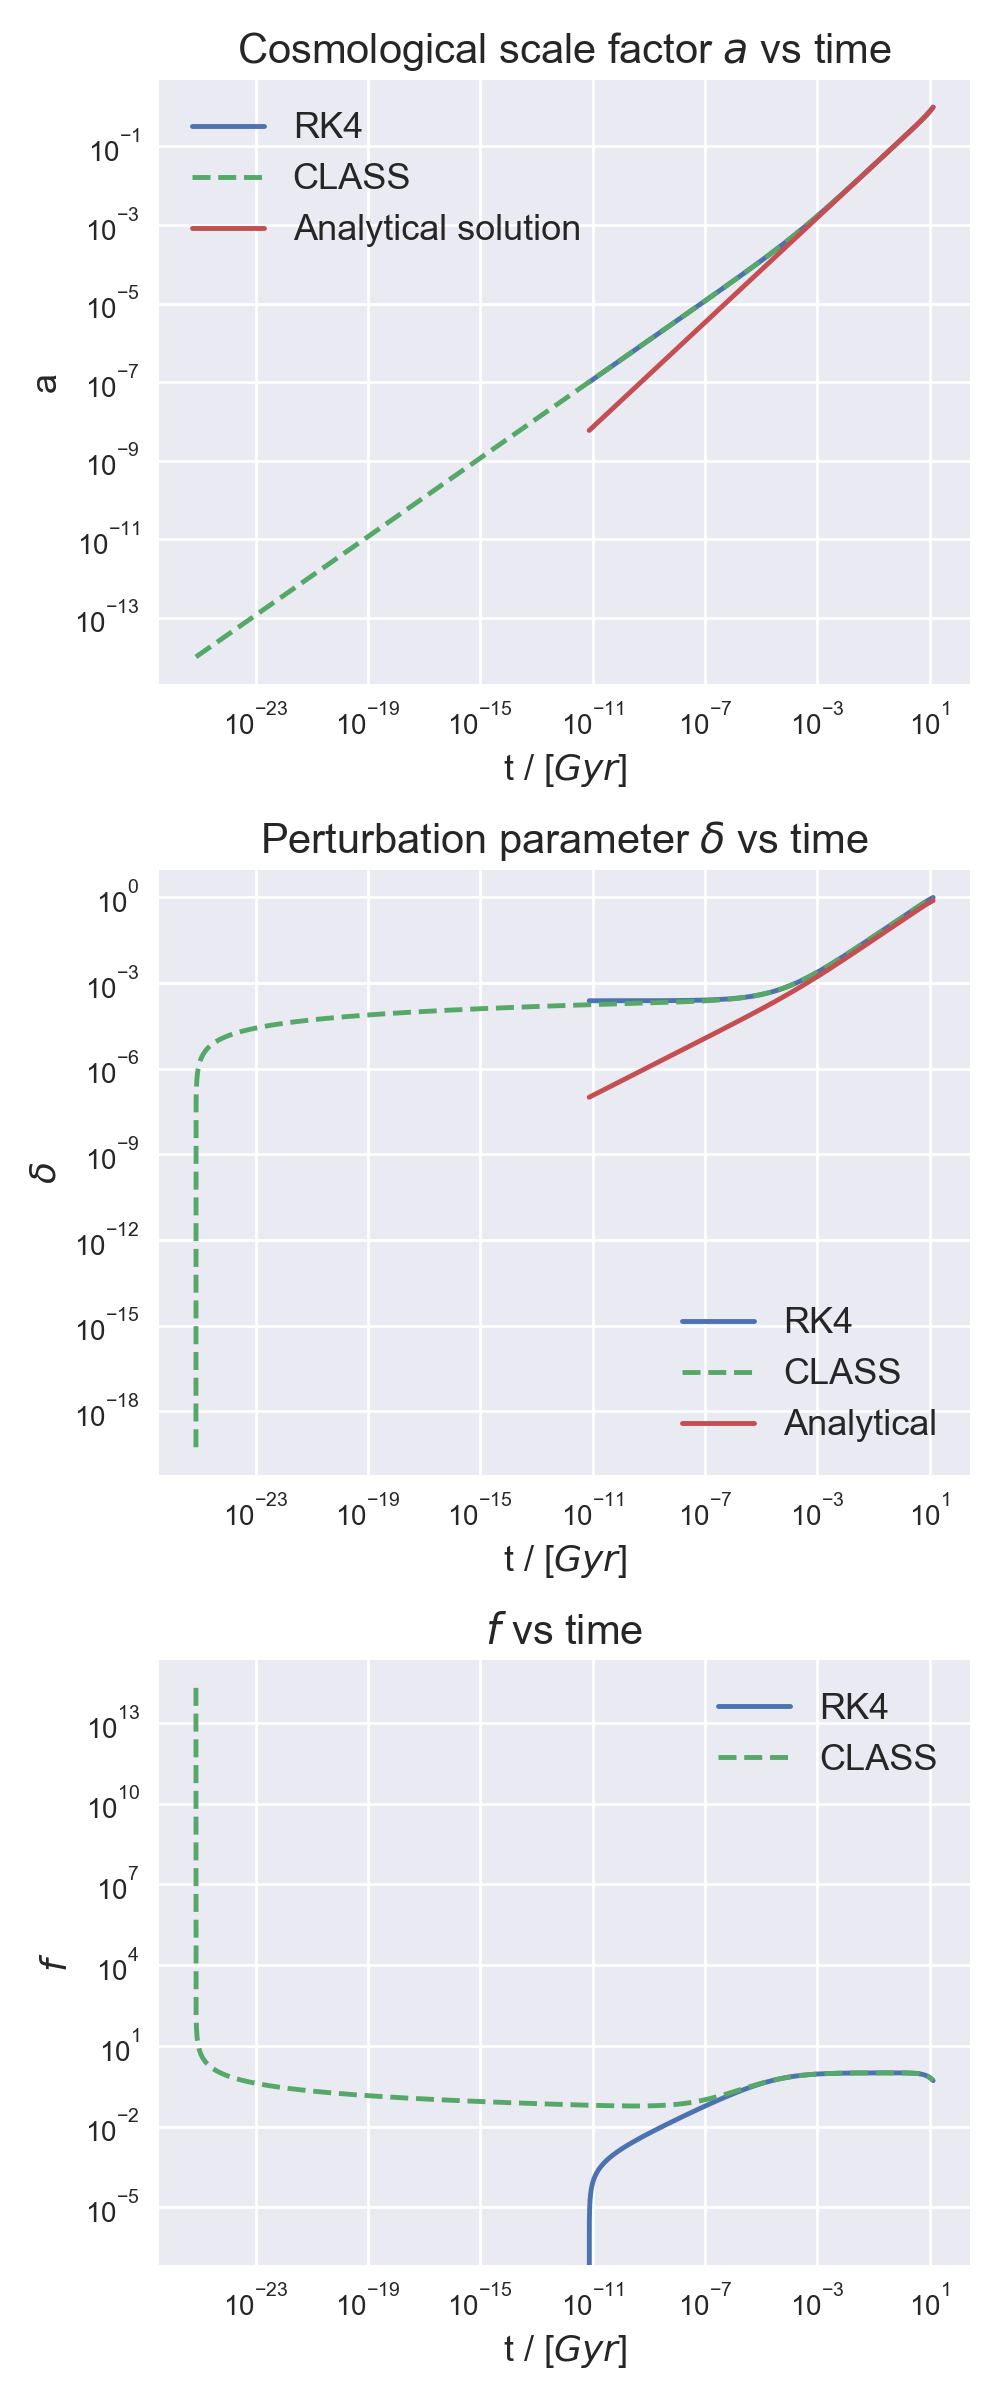

Text(0.5, 1.0, '$f$ vs time')

In [166]:
fig,ax = plt.subplots(3,1,tight_layout=True,figsize=(5,12))
ax[0].plot(ts,vals[:,2],label='RK4')
ax[0].plot(bg['proper time [Gyr]'], 1/(1 + bg['z']), label='CLASS', ls='--')
ax[0].plot(ts,analyticalAs, label='Analytical solution')
ax[0].legend(fontsize=13)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel(r't / [$Gyr$]',fontsize=13)
ax[0].set_ylabel('a',fontsize=13)
ax[0].set_title(r'Cosmological scale factor $a$ vs time',fontsize=15)
#ax[0].set_xlim(1e-14,10)

dtoday = np.interp(1, vals[:,2], vals[:,0])

ax[1].plot(ts,vals[:,0]/dtoday,label='RK4')
ax[1].plot(bg['proper time [Gyr]'], d, label='CLASS', ls='--')
ax[1].plot(ts,analyticalDs,label='Analytical')
ax[1].legend(fontsize=13)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel(r't / [$Gyr$]',fontsize=13)
ax[1].set_ylabel(r'$\delta$',fontsize=13)
ax[1].set_title(r'Perturbation parameter $\delta$ vs time',fontsize=15)
ax[1].legend(fontsize=13)

ax[2].plot(ts,fs,label='RK4')
ax[2].plot(bg['proper time [Gyr]'], f, label='CLASS', ls='--')
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].legend(fontsize=13)
ax[2].set_xscale('log')
ax[2].set_xlabel(r't / [$Gyr$]',fontsize=13)
ax[2].set_ylabel(r'$f$',fontsize=13)
ax[2].set_title(r'$f$ vs time',fontsize=15)